# Lab Question 7: Discrete Time Warping (DTW) on Audio Signals

**Objective:** Compare two audio signals (User's voice vs. Friend's voice saying "hello") using Dynamic Time Warping to analyze their similarity despite temporal differences.

### Tasks:
1. Load audio signals.
2. Convert to numerical time series.
3. Normalize amplitude.
4. Apply DTW.
5. Visualize alignment and compute distance.
6. Interpret results.

In [15]:
# Install necessary library if not already installed
#!pip install librosa matplotlib numpy

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

# --- Configuration ---
# We use a lower sample rate for DTW on raw waveforms to keep computation fast for this lab.
SAMPLE_RATE = 2000 

print("Libraries imported successfully.")

Libraries imported successfully.


## Step 1 & 2: Load or Record Audio
Please record two files named `my_hello.wav` and `friend_hello.wav` and place them in the same folder as this notebook.

*Note: If you do not have files ready, the code below will generate synthetic 'hello-like' signals so you can test the algorithm immediately.*

In [17]:
def generate_synthetic_audio(duration, freq_start, freq_end, sr=2000):
    """Generates a synthetic chirp signal to mimic a simple word like 'hello'."""
    t = np.linspace(0, duration, int(sr * duration))
    # Create a signal that varies in frequency (chirp)
    signal = np.sin(2 * np.pi * np.linspace(freq_start, freq_end, len(t)) * t)
    # Apply an envelope to fade in and out
    envelope = np.exp(-3 * (t - duration/2)**2)
    return signal * envelope

try:
    # OPTION A: Load Real Audio Files
    # Replace 'my_hello.wav' and 'friend_hello.wav' with your actual file paths
    y1, sr1 = librosa.load('voice 1.m4a', sr=SAMPLE_RATE)
    y2, sr2 = librosa.load('voice 2.m4a', sr=SAMPLE_RATE)
    print("Loaded real audio files.")

except FileNotFoundError:
    # OPTION B: Generate Synthetic Data (Fallback)
    print("Audio files not found. Generating synthetic signals for demonstration...")
    
    # Signal 1: Standard 'Hello'
    y1 = generate_synthetic_audio(duration=1.0, freq_start=300, freq_end=100, sr=SAMPLE_RATE)
    
    # Signal 2: Friend's 'Hello' (Slightly slower, different pitch, slightly delayed)
    # We add zeros to the start to simulate a delay (time shift)
    y2_part = generate_synthetic_audio(duration=1.2, freq_start=350, freq_end=120, sr=SAMPLE_RATE)
    y2 = np.concatenate([np.zeros(500), y2_part]) # 500 sample delay

# Ensure they are standard numpy arrays
y1 = np.array(y1)
y2 = np.array(y2)

C:\Users\shish\AppData\Local\Temp\ipykernel_23952\2666970373.py:13: UserWarning: PySoundFile failed. Trying audioread instead.
  y1, sr1 = librosa.load('voice 1.m4a', sr=SAMPLE_RATE)


Loaded real audio files.


C:\Users\shish\AppData\Local\Temp\ipykernel_23952\2666970373.py:14: UserWarning: PySoundFile failed. Trying audioread instead.
  y2, sr2 = librosa.load('voice 2.m4a', sr=SAMPLE_RATE)


## Step 3: Normalize Signals
To compare the *shape* of the waveforms rather than their loudness, we normalize the amplitude so both signals range between -1 and 1.

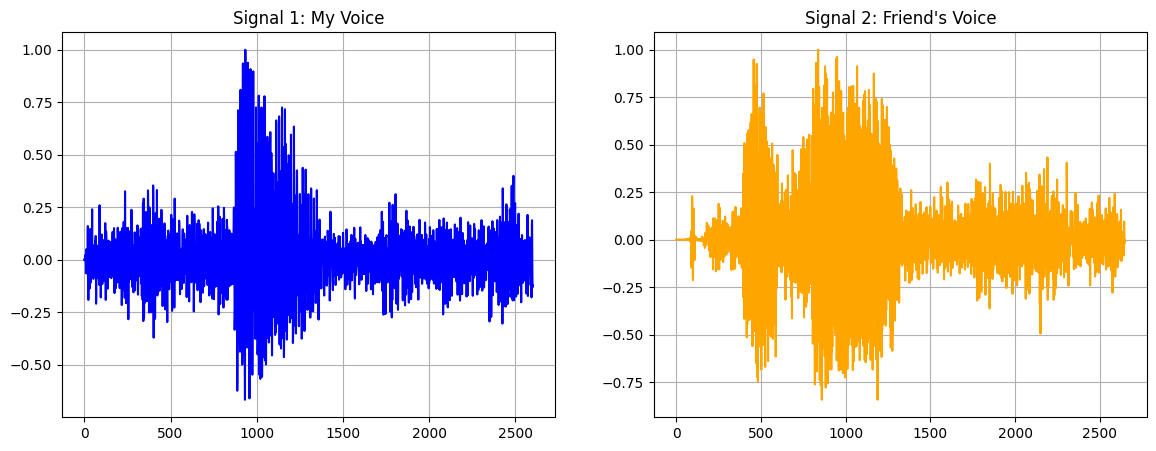

In [18]:
def normalize_signal(y):
    return y / np.max(np.abs(y))

y1_norm = normalize_signal(y1)
y2_norm = normalize_signal(y2)

# Plot the raw (normalized) signals before DTW
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(y1_norm, label='Signal 1 (My Voice)', color='blue')
plt.title("Signal 1: My Voice")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(y2_norm, label='Signal 2 (Friend)', color='orange')
plt.title("Signal 2: Friend's Voice")
plt.grid(True)
plt.show()

## Step 4: Apply Dynamic Time Warping (DTW)
We calculate the DTW distance and the warping path. 

*Note: We are using Euclidean distance on the raw waveform values.*

In [19]:
# Compute DTW
# librosa.sequence.dtw computes the alignment between two sequences
# D is the cumulative cost matrix
# wp is the warping path (indices of the alignment)
D, wp = librosa.sequence.dtw(y1_norm, y2_norm, metric='euclidean')

# Calculate total distance (normalized by path length for fair comparison)
total_distance = D[-1, -1]
normalized_distance = total_distance / len(wp)

print(f"Total DTW Distance: {total_distance:.4f}")
print(f"Normalized DTW Distance: {normalized_distance:.4f}")

Total DTW Distance: 329.2196
Normalized DTW Distance: 0.0978


## Step 5: Visualization of Alignment Path
We will plot the Cost Matrix and the Optimal Warping Path (the white line). The warping path shows how Signal 2 maps to Signal 1.

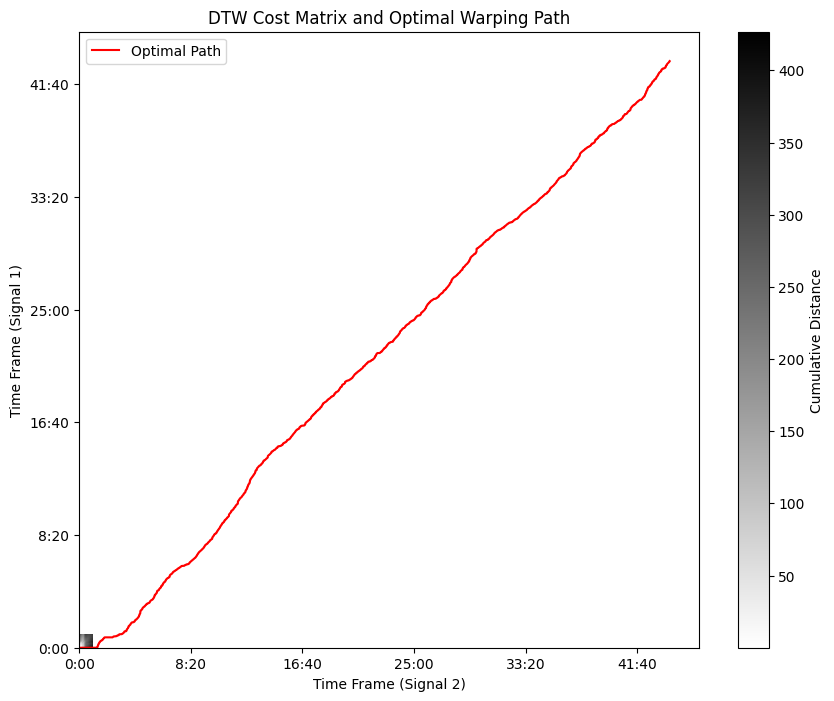

In [20]:
plt.figure(figsize=(10, 8))

# Display the cost matrix
librosa.display.specshow(D, x_axis='time', y_axis='time', cmap='gray_r')

# Plot the path
plt.plot(wp[:, 1], wp[:, 0], label='Optimal Path', color='r')
plt.title('DTW Cost Matrix and Optimal Warping Path')
plt.xlabel('Time Frame (Signal 2)')
plt.ylabel('Time Frame (Signal 1)')
plt.legend()
plt.colorbar(label='Cumulative Distance')
plt.show()

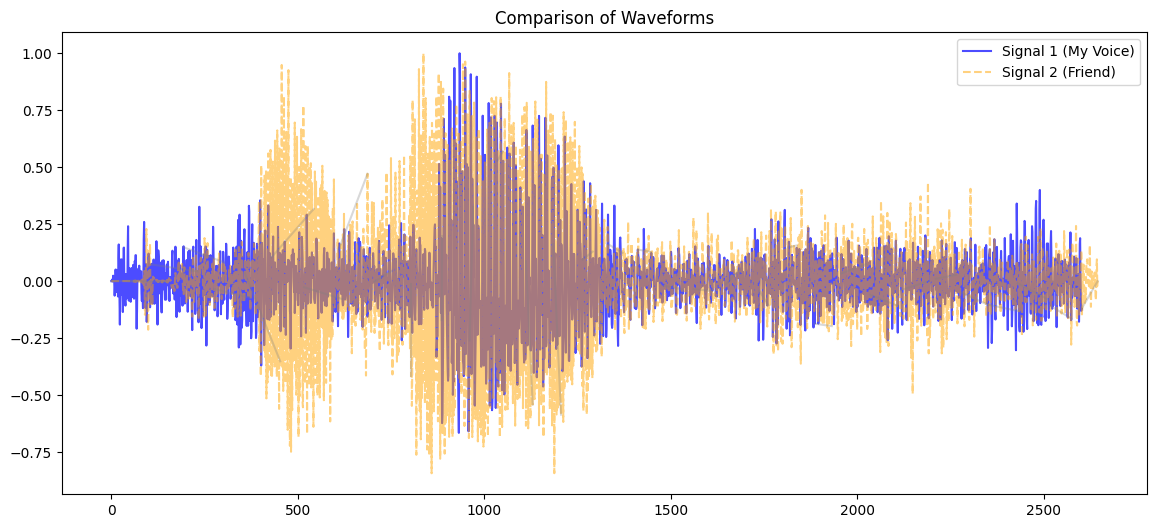

In [21]:
# Visualization of the Aligned Signals
plt.figure(figsize=(14, 6))

# Plot Signal 1
plt.plot(y1_norm, label='Signal 1 (My Voice)', color='blue', alpha=0.7)

# Plot Signal 2, but shifted/warped visually to match Signal 1 based on the path
# Note: This is a simplified visualization to show they occupy similar amplitude spaces
plt.plot(y2_norm, label='Signal 2 (Friend)', color='orange', alpha=0.5, linestyle='--')

# Draw connecting lines between matching points (visualizing the warp)
# We only draw a subset of lines to keep the plot clean
step = 100
for i in range(0, len(wp), step):
    idx1, idx2 = wp[i]
    plt.plot([idx1, idx2], [y1_norm[idx1], y2_norm[idx2]], color='gray', alpha=0.3)

plt.title("Comparison of Waveforms")
plt.legend()
plt.show()

## Step 6: Interpretation of Results

### 1. Similarity Analysis
- **Distance Value:** The computed `Normalized DTW Distance` quantifies the similarity. A value closer to **0** indicates the signals are very similar. A high value indicates they are different.
- **Visual Inspection:** Looking at the Cost Matrix, the **diagonal red line (the path)** indicates the match. If the line is perfectly straight (45 degrees), the two recordings were spoken at the exact same speed. Deviations from the straight diagonal indicate where the algorithm had to "warp" time.

### 2. How DTW helps match patterns not aligned in time
Dynamic Time Warping solves the problem of **speed variance** in speech processing.

1.  **Non-Linear Matching:** Unlike Euclidean distance, which compares the $i$-th sample of Signal A strictly with the $i$-th sample of Signal B, DTW compares one sample from Signal A with *multiple* samples from Signal B (and vice versa).
2.  **Handling Delays:** If your friend paused slightly before saying "hello", their waveform would be shifted to the right. Euclidean distance would result in a huge error because it would compare silence to sound. DTW detects this shift and maps the silence to silence, and the speech onset to speech onset.
3.  **Handling Speaking Rate:** If you speak slowly and your friend speaks quickly, DTW "stretches" the friend's signal (or compresses yours) in the time dimension to find the optimal alignment that minimizes the amplitude difference.